In [1]:
# === STEP 1 — Cell 1: Setup & Config ===
import os, sys, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

RANDOM_STATE = 42  # untuk reprodusibilitas
pd.set_option("display.max_columns", 120)  # agar tabel tidak terpotong

# Deteksi lingkungan Colab (opsional, aman jika bukan Colab)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

# Konfigurasi nama file (ganti kalau kamu pakai nama lain)
DATA_FILE = "train.csv"
DESC_FILE = "deskripsi data.txt"  # opsional (jika ada deskripsi kolom)
print("Setup OK. IN_COLAB =", IN_COLAB)

Setup OK. IN_COLAB = True


In [2]:
# === STEP 1 — Cell 2: Load Data + Quick Peek ===
if not os.path.exists(DATA_FILE) and IN_COLAB:
    from google.colab import files
    print(f"File {DATA_FILE} tidak ditemukan. Silakan upload CSV...")
    uploaded = files.upload()
    # Jika nama file berbeda, pakai file pertama yang diupload
    if DATA_FILE not in uploaded and len(uploaded) > 0:
        DATA_FILE = list(uploaded.keys())[0]
        print("Menggunakan file:", DATA_FILE)

# Baca CSV
assert os.path.exists(DATA_FILE), f"File {DATA_FILE} tidak ditemukan."
try:
    df = pd.read_csv(DATA_FILE)  # jika ada error encoding, coba: encoding='utf-8'
except UnicodeDecodeError:
    df = pd.read_csv(DATA_FILE, encoding='latin-1')

print(">> Data loaded.")
print("Shape:", df.shape)
display(df.head(3))

>> Data loaded.
Shape: (83293, 33)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0.0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314.0,NaN,0,Transient,38.4,0,0,Check-Out,2019-01-14,1
1,"Greensboro Courtyard Greensboro, NC",1,524,2018,December,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,NaN,0,Transient,62.8,0,0,Canceled,2017-10-21,2
2,"The Westin Peachtree Plaza, Atlanta Atlanta, GA",1,175,2019,May,20,19,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,12.0,NaN,0,Transient,110.0,0,0,Canceled,2018-11-25,3


In [3]:
# === STEP 1 — Cell 3: Target + Leakage Peek + Dtypes ===
# Deteksi kolom target standar untuk dataset ini
target_candidates = [c for c in ["is_canceled", "cancelled", "is_cancelled"] if c in df.columns]
assert len(target_candidates) > 0, "Kolom target (is_canceled / cancelled / is_cancelled) tidak ditemukan."
TARGET = target_candidates[0]
print("Target column:", TARGET)

# Leakage candidates (laporan saja di Step 1; treatment drop ada di Step 2)
leak_peek = [c for c in ["reservation_status", "reservation_status_date"] if c in df.columns]
print("Leakage candidates (report only):", leak_peek)

# Ringkasan tipe data
print("\nDtypes count:")
print(df.dtypes.value_counts())

Target column: is_canceled
Leakage candidates (report only): ['reservation_status', 'reservation_status_date']

Dtypes count:
int64      17
object     12
float64     4
Name: count, dtype: int64


In [4]:
# === STEP 1 — Cell 4: Duplicate Checks ===
dup_full = df.duplicated().sum()
print(f"Duplicated rows (full-row): {dup_full}")

if "bookingID" in df.columns:
    dup_key = df.duplicated(subset=["bookingID"]).sum()
    print(f"Duplicated by bookingID: {dup_key}")
else:
    print("Kolom bookingID tidak ada/opsional — dedup by key dilewati.")

Duplicated rows (full-row): 0
Duplicated by bookingID: 0


In [5]:
# === STEP 1 — Cell 5: Missing Overview + Target Distribution + Deskripsi (opsional) ===
# Missing ratio Top-20
missing_ratio = df.isna().mean().sort_values(ascending=False)
print("Top-20 missing ratio:")
display(missing_ratio.head(20))

# Distribusi target (cek imbalance)
print("\nTarget distribution:")
display(
    df[TARGET]
      .value_counts(dropna=False)
      .to_frame(name="count")
      .assign(ratio=lambda t: (t["count"] / t["count"].sum()).round(4))
)

# (Opsional) Baca deskripsi data jika ada
if os.path.exists(DESC_FILE):
    print(f"\n>> Menemukan {DESC_FILE}. Cuplikan deskripsi kolom:")
    try:
        with open(DESC_FILE, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
        print("".join(lines[:60]))  # tampilkan sebagian agar ringkas
    except Exception as e:
        print("Gagal membaca deskripsi:", e)
else:
    print(f"Tidak menemukan file deskripsi: {DESC_FILE} (opsional).")

Top-20 missing ratio:


,0
company,0.943164
agent,0.136914
country,0.004154
children,0.000036
hotel,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
is_canceled,0.000000
lead_time,0.000000
stays_in_week_nights,0.000000



Target distribution:


,count,ratio
is_canceled,,
0,52516,0.6305
1,30777,0.3695



>> Menemukan deskripsi data.txt. Cuplikan deskripsi kolom:
hotel: Type of hotel (Categorical)

is_canceled: Whether the booking was canceled or not (Binary)

lead_time: Number of days between booking date and arrival date (Numeric)

arrival_date_year: The year of the arrival date (Numeric)

arrival_date_month: The month of the arrival date (Categorical)

arrival_date_week_number: The week number of the arrival date (Numeric)

arrival_date_day_of_month: The day of the month of the arrival date (Numeric)

stays_in_weekend_nights: Number of weekend nights stayed or booked to stay at the hotel (Numeric)

stays_in_week_nights: Number of week nights stayed or booked to stay at the hotel (Numeric)

adults, children, babies: Number of guests categorized by age groups

adults = Number of adults
children = Number of children
babies = Number infants
Booking Details:

meal: Type(s) food option(s) included in booking package (Categorical)
country & market_segment & distribution_channel columns pro

In [6]:
# === STEP 2 — Cell 1: Start Audit ===
import numpy as np, pandas as pd

# Bekerja pada salinan supaya df asli tetap ada untuk referensi
df2 = df.copy()
print("Awal audit — df2 shape:", df2.shape)
print("Target:", TARGET)

Awal audit — df2 shape: (83293, 33)
Target: is_canceled


In [7]:
# === STEP 2 — Cell 2: Dedup ===
before = df2.shape[0]

# 2.1 Duplikat full-row
dup_full = df2.duplicated().sum()
if dup_full > 0:
    df2 = df2.drop_duplicates(keep="first").copy()
    print(f"Dedup full-row: drop {dup_full}")

# 2.2 Duplikat berdasarkan bookingID (jika ada)
if "bookingID" in df2.columns:
    dup_key = df2.duplicated(subset=["bookingID"]).sum()
    if dup_key > 0:
        df2 = df2.drop_duplicates(subset=["bookingID"], keep="last").copy()
        print(f"Dedup by bookingID: drop {dup_key} (keep last)")

after = df2.shape[0]
print(f"Selesai dedup. Rows: {before} → {after}")

Selesai dedup. Rows: 83293 → 83293


In [8]:
# === STEP 2 — Cell 3: Anti-Leakage ===
leak_cols = [c for c in ["reservation_status", "reservation_status_date"] if c in df2.columns]
if leak_cols:
    df2 = df2.drop(columns=leak_cols).copy()
    print("Dropped leakage columns:", leak_cols)
else:
    print("Tidak ada kolom leakage standar ditemukan.")

Dropped leakage columns: ['reservation_status', 'reservation_status_date']


In [9]:
# === STEP 2 — Cell 4: High Missing Columns ===
missing_ratio = df2.isna().mean().sort_values(ascending=False)
HIGH_MISS_THR = 0.40
high_missing_cols = missing_ratio[missing_ratio > HIGH_MISS_THR].index.tolist()

if len(high_missing_cols) > 0:
    df2 = df2.drop(columns=high_missing_cols).copy()
    print("Dropped high-missing (>40%):", high_missing_cols)
else:
    print("Tidak ada kolom dengan missing > 40%.")

Dropped high-missing (>40%): ['company']


In [10]:
# === STEP 2 — Cell 5: Type Handling & ID → kategori ===
# Agent/Company numerik → jadikan string (kategori) agar tidak dianggap ordinal
for id_like in ["agent","company"]:
    if id_like in df2.columns:
        df2[id_like] = (df2[id_like]
                        .fillna(-1)
                        .astype(float)
                        .astype(int)
                        .astype(str))

# Normalisasi contoh: country ke uppercase (jika ada & object)
if "country" in df2.columns and df2["country"].dtype == "object":
    df2["country"] = df2["country"].str.upper()

print("Penanganan tipe/ID selesai.")

Penanganan tipe/ID selesai.


In [11]:
# === STEP 2 — Cell 6: Feature Engineering ===
# 1) total malam
if set(["stays_in_weekend_nights","stays_in_week_nights"]).issubset(df2.columns):
    df2["stays_total_nights"] = df2["stays_in_weekend_nights"].fillna(0) + df2["stays_in_week_nights"].fillna(0)

# 2) total tamu
for col in ["adults","children","babies"]:
    if col in df2.columns:
        df2[col] = df2[col].fillna(0)
if set(["adults","children","babies"]).issubset(df2.columns):
    df2["total_guests"] = df2["adults"] + df2["children"] + df2["babies"]

# 3) flag ganti kamar
if set(["reserved_room_type","assigned_room_type"]).issubset(df2.columns):
    df2["room_changed"] = (df2["reserved_room_type"].astype(str) != df2["assigned_room_type"].astype(str)).astype(int)

# 4) arrival month → angka (dukung 'Jan' atau 'January')
if "arrival_date_month" in df2.columns:
    import calendar
    s = df2["arrival_date_month"].dropna().astype(str)
    if len(s) and s.str.len().max() <= 3:
        month_map = {m[:3]:i for i,m in enumerate(calendar.month_name) if m}
    else:
        month_map = {m:i for i,m in enumerate(calendar.month_name) if m}
    df2["arrival_month_num"] = df2["arrival_date_month"].astype(str).map(month_map)

fe_cols = [c for c in ["stays_total_nights","total_guests","room_changed","arrival_month_num"] if c in df2.columns]
print("Fitur engineered:", fe_cols)

Fitur engineered: ['stays_total_nights', 'total_guests', 'room_changed', 'arrival_month_num']


In [12]:
# === STEP 2 — Cell 7: Rare Category Collapsing ===
RARE_THR = 0.005  # 0.5%
cat_cols_tmp = df2.select_dtypes(include=["object"]).columns.tolist()

for c in cat_cols_tmp:
    freq = df2[c].value_counts(normalize=True, dropna=False)
    rare_levels = freq[freq < RARE_THR].index
    if len(rare_levels) > 0:
        df2.loc[df2[c].isin(rare_levels), c] = "Other"

print("Rare category collapsing selesai (threshold 0.5%).")

Rare category collapsing selesai (threshold 0.5%).


In [13]:
# === STEP 2 — Cell 8: Outlier Treatment ADR ===
if "adr" in df2.columns:
    # adr minimal 0
    df2.loc[df2["adr"] < 0, "adr"] = 0
    # winsorize 1–99%
    lo, hi = df2["adr"].quantile([0.01, 0.99])
    df2["adr"] = df2["adr"].clip(lo, hi)
    print(f"Clipped 'adr' ke 1–99 persentil: {lo:.2f}–{hi:.2f}")
else:
    print("Kolom 'adr' tidak ditemukan (lewati outlier treatment).")

Clipped 'adr' ke 1–99 persentil: 0.00–252.00


In [14]:
# === STEP 2 — Cell 9: Finalize ===
assert TARGET in df2.columns, "Target hilang dari df2 secara tidak sengaja."

# Set X,y final untuk modelling
y = df2[TARGET].astype(int)
X_prepared = df2.drop(columns=[TARGET]).copy()

# Daftar kolom per tipe
num_cols = X_prepared.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_prepared.select_dtypes(include=["object"]).columns.tolist()

print("[STEP 2 SUMMARY]")
print("X_prepared:", X_prepared.shape, "| y:", y.shape)
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

# Missing setelah treatment (Top 15)
post_missing = X_prepared.isna().mean().sort_values(ascending=False).head(15)
print("\nTop-15 missing ratio (post-treatment):")
display(post_missing)

# Preview fitur engineered (jika ada)
fe_cols = [c for c in ["stays_total_nights","total_guests","room_changed","arrival_month_num"] if c in X_prepared.columns]
if fe_cols:
    print("\nPreview engineered features:")
    display(X_prepared[fe_cols].head(5))

[STEP 2 SUMMARY]
X_prepared: (83293, 33) | y: (83293,)
Numeric cols: 22 | Categorical cols: 11

Top-15 missing ratio (post-treatment):


,0
hotel,0.0
lead_time,0.0
arrival_date_year,0.0
arrival_date_month,0.0
arrival_date_week_number,0.0
arrival_date_day_of_month,0.0
stays_in_weekend_nights,0.0
stays_in_week_nights,0.0
adults,0.0
children,0.0



Preview engineered features:


,stays_total_nights,total_guests,room_changed,arrival_month_num
0,4,2.0,0,1
1,2,2.0,0,12
2,3,2.0,0,5
3,1,1.0,0,10
4,5,2.0,0,9


In [15]:
# === STEP 3 — Cell 1: Train/Valid Split (Stratified) ===
from sklearn.model_selection import train_test_split

assert 'X_prepared' in globals() and 'y' in globals(), "Jalankan STEP 2 terlebih dahulu."
RANDOM_STATE = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    X_prepared, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "| Valid:", X_valid.shape)
print("Target balance (train):")
print(y_train.value_counts(normalize=True).round(4))

Train: (66634, 33) | Valid: (16659, 33)
Target balance (train):
is_canceled
0    0.6305
1    0.3695
Name: proportion, dtype: float64


In [16]:
# === STEP 3 — Cell 2: Preprocessors (Linear vs Tree) ===
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Ambil ulang tipe kolom dari X_train (aman jika STEP 2 mengubah kolom)
num_cols_s3 = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_s3 = X_train.select_dtypes(include=["object"]).columns.tolist()

def make_preprocessor_linear(num_cols, cat_cols):
    transformers = []
    if len(num_cols) > 0:
        transformers.append(("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols))
    if len(cat_cols) > 0:
        transformers.append(("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols))
    assert len(transformers) > 0, "Tidak ada fitur numeric maupun categorical."
    return ColumnTransformer(transformers=transformers)

def make_preprocessor_tree(num_cols, cat_cols):
    transformers = []
    if len(num_cols) > 0:
        transformers.append(("num", SimpleImputer(strategy="median"), num_cols))
    if len(cat_cols) > 0:
        transformers.append(("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols))
    assert len(transformers) > 0, "Tidak ada fitur numeric maupun categorical."
    return ColumnTransformer(transformers=transformers)

prep_linear = make_preprocessor_linear(num_cols_s3, cat_cols_s3)  # untuk Logistic
prep_tree   = make_preprocessor_tree(num_cols_s3, cat_cols_s3)    # untuk Dummy/RF

print("Preprocessors siap. num:", len(num_cols_s3), "| cat:", len(cat_cols_s3))

Preprocessors siap. num: 22 | cat: 11


In [17]:
# === STEP 3 — Cell 3: Define Models ===
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pipe_dummy = Pipeline([
    ("prep", prep_tree),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

pipe_logit = Pipeline([
    ("prep", prep_linear),
    ("clf", LogisticRegression(max_iter=400))  # bisa tambah class_weight='balanced' jika recall penting
])

pipe_rf = Pipeline([
    ("prep", prep_tree),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

print("Models siap: Dummy, Logistic, RandomForest")

Models siap: Dummy, Logistic, RandomForest


In [18]:
# === STEP 3 — Cell 4: Evaluator & Threshold Tuning Helpers ===
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             precision_score, recall_score, classification_report,
                             confusion_matrix, precision_recall_curve)

def evaluate_proba(model, Xv, yv, name="model", thr=0.5):
    proba = model.predict_proba(Xv)[:, 1]
    preds = (proba >= thr).astype(int)
    return {
        "name": name,
        "thr": thr,
        "roc": roc_auc_score(yv, proba),
        "pr": average_precision_score(yv, proba),
        "f1": f1_score(yv, preds, zero_division=0),
        "precision": precision_score(yv, preds, zero_division=0),
        "recall": recall_score(yv, preds, zero_division=0),
        "report": classification_report(yv, preds, digits=3, zero_division=0),
        "cm": confusion_matrix(yv, preds),
        "proba": proba
    }

def best_threshold_by_f1(proba, y_true):
    precisions, recalls, thresholds = precision_recall_curve(y_true, proba)
    if len(thresholds) == 0:
        return 0.5
    f1s, thr_list = [], []
    for p, r, t in zip(precisions[1:], recalls[1:], thresholds):
        if p + r > 0:
            f1s.append(2*p*r/(p+r))
            thr_list.append(t)
    return float(thr_list[int(np.argmax(f1s))]) if f1s else 0.5

def summary_table(*res_list):
    import pandas as pd
    rows = []
    for r in res_list:
        rows.append([r["name"], r["thr"], r["roc"], r["pr"], r["f1"], r["precision"], r["recall"]])
    return pd.DataFrame(rows, columns=["Model","Thr","ROC-AUC","PR-AUC","F1","Precision","Recall"])\
             .sort_values(["ROC-AUC","PR-AUC"], ascending=False).reset_index(drop=True)

print("Evaluator siap.")

Evaluator siap.


In [19]:
# === STEP 3 — Cell 5: Train & Eval @ thr=0.5 ===
pipe_dummy.fit(X_train, y_train)
res_dummy = evaluate_proba(pipe_dummy, X_valid, y_valid, "Dummy (thr=0.5)")

pipe_logit.fit(X_train, y_train)
res_logit = evaluate_proba(pipe_logit, X_valid, y_valid, "Logistic (thr=0.5)")

pipe_rf.fit(X_train, y_train)
res_rf = evaluate_proba(pipe_rf, X_valid, y_valid, "RandomForest (thr=0.5)")

summary_05 = summary_table(res_dummy, res_logit, res_rf)
summary_05

,Model,Thr,ROC-AUC,PR-AUC,F1,Precision,Recall
0,RandomForest (thr=0.5),0.5,0.956787,0.936871,0.847309,0.861242,0.833821
1,Logistic (thr=0.5),0.5,0.913019,0.874938,0.755043,0.816431,0.702242
2,Dummy (thr=0.5),0.5,0.500000,0.369530,0.000000,0.000000,0.000000


In [20]:
# === STEP 3 — Cell 6: Threshold Tuning (maximize F1) ===
best_thr_logit = best_threshold_by_f1(res_logit["proba"], y_valid)
res_logit_tuned = evaluate_proba(pipe_logit, X_valid, y_valid, f"Logistic (thr={best_thr_logit:.3f})", thr=best_thr_logit)

best_thr_rf = best_threshold_by_f1(res_rf["proba"], y_valid)
res_rf_tuned = evaluate_proba(pipe_rf, X_valid, y_valid, f"RandomForest (thr={best_thr_rf:.3f})", thr=best_thr_rf)

summary_tuned = summary_table(res_dummy, res_logit, res_rf, res_logit_tuned, res_rf_tuned)
summary_tuned

,Model,Thr,ROC-AUC,PR-AUC,F1,Precision,Recall
0,RandomForest (thr=0.5),0.500000,0.956787,0.936871,0.847309,0.861242,0.833821
1,RandomForest (thr=0.449),0.448802,0.956787,0.936871,0.852691,0.834968,0.871183
2,Logistic (thr=0.5),0.500000,0.913019,0.874938,0.755043,0.816431,0.702242
3,Logistic (thr=0.357),0.357132,0.913019,0.874938,0.784826,0.740245,0.835120
4,Dummy (thr=0.5),0.500000,0.500000,0.369530,0.000000,0.000000,0.000000


In [21]:
# === STEP 3 — Cell 7: Ringkasan & Pilih Kandidat ===
import pandas as pd

print("=== Summary @0.5 ===")
display(summary_05.style.format({"ROC-AUC":"{:.3f}","PR-AUC":"{:.3f}","F1":"{:.3f}","Precision":"{:.3f}","Recall":"{:.3f}"}))

print("\n=== Summary (with tuned thresholds) ===")
display(summary_tuned.style.format({"ROC-AUC":"{:.3f}","PR-AUC":"{:.3f}","F1":"{:.3f}","Precision":"{:.3f}","Recall":"{:.3f}"}))

# Pilih kandidat terbaik by ROC, lalu lihat report tuned-nya
candidates = {
    res_logit_tuned["name"]: res_logit_tuned,
    res_rf_tuned["name"]: res_rf_tuned
}
best_name = max(candidates.keys(), key=lambda k: candidates[k]["roc"])
best_res = candidates[best_name]

print(f"\nKandidat terbaik (by ROC): {best_name}")
print("\nConfusion Matrix (tuned):")
print(best_res["cm"])
print("\nClassification Report (tuned):")
print(best_res["report"])

=== Summary @0.5 ===


,Model,Thr,ROC-AUC,PR-AUC,F1,Precision,Recall
0,RandomForest (thr=0.5),0.500000,0.957,0.937,0.847,0.861,0.834
1,Logistic (thr=0.5),0.500000,0.913,0.875,0.755,0.816,0.702
2,Dummy (thr=0.5),0.500000,0.500,0.370,0.000,0.000,0.000



=== Summary (with tuned thresholds) ===


,Model,Thr,ROC-AUC,PR-AUC,F1,Precision,Recall
0,RandomForest (thr=0.5),0.500000,0.957,0.937,0.847,0.861,0.834
1,RandomForest (thr=0.449),0.448802,0.957,0.937,0.853,0.835,0.871
2,Logistic (thr=0.5),0.500000,0.913,0.875,0.755,0.816,0.702
3,Logistic (thr=0.357),0.357132,0.913,0.875,0.785,0.740,0.835
4,Dummy (thr=0.5),0.500000,0.500,0.370,0.000,0.000,0.000



Kandidat terbaik (by ROC): RandomForest (thr=0.449)

Confusion Matrix (tuned):
[[9443 1060]
 [ 793 5363]]

Classification Report (tuned):
              precision    recall  f1-score   support

           0      0.923     0.899     0.911     10503
           1      0.835     0.871     0.853      6156

    accuracy                          0.889     16659
   macro avg      0.879     0.885     0.882     16659
weighted avg      0.890     0.889     0.889     16659



In [22]:
# === STEP 4 — Cell 1: Select Best Model & Threshold ===
import numpy as np, pandas as pd

# Kumpulkan kandidat tuned (jika ada)
candidates = {}
if 'res_logit_tuned' in globals():
    candidates[res_logit_tuned["name"]] = {"res": res_logit_tuned, "pipe": pipe_logit}
if 'res_rf_tuned' in globals():
    candidates[res_rf_tuned["name"]]   = {"res": res_rf_tuned,   "pipe": pipe_rf}

assert candidates, "Tidak menemukan hasil tuned. Pastikan STEP 3, Cell 6 sudah dijalankan."

# Pilih terbaik by ROC-AUC (bisa ganti ke PR-AUC jika imbalance sangat berat)
best_name = max(candidates.keys(), key=lambda k: candidates[k]["res"]["roc"])
best_res  = candidates[best_name]["res"]
best_pipe = candidates[best_name]["pipe"]
best_thr  = best_res["thr"]

print("Best model:", best_name)
print("ROC-AUC =", round(best_res["roc"],3), "| PR-AUC =", round(best_res["pr"],3), "| Thr =", round(best_thr,3))
print("\nConfusion Matrix @thr:", best_thr, "\n", best_res["cm"])
print("\nClassification Report @thr:")
print(best_res["report"])

# Simpan ulang proba untuk keperluan plotting/simulasi
proba_best = best_res["proba"]

Best model: RandomForest (thr=0.449)
ROC-AUC = 0.957 | PR-AUC = 0.937 | Thr = 0.449

Confusion Matrix @thr: 0.4488015272208741 
 [[9443 1060]
 [ 793 5363]]

Classification Report @thr:
              precision    recall  f1-score   support

           0      0.923     0.899     0.911     10503
           1      0.835     0.871     0.853      6156

    accuracy                          0.889     16659
   macro avg      0.879     0.885     0.882     16659
weighted avg      0.890     0.889     0.889     16659



In [23]:
# === STEP 4 — Cell 2: Utilities — Get Feature Names from ColumnTransformer ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def get_feature_names_from_ct(ct: ColumnTransformer):
    """
    Mengembalikan daftar nama fitur setelah transformasi (num + OHE cat).
    Catatan: Asumsikan ada transformer bernama 'num' dan 'cat' seperti di STEP 3.
    """
    feat_names = []
    # numeric
    num_names = []
    for name, trans, cols in ct.transformers_:
        if name == "num":
            # Jika pipeline → ambil list kolom numeric asli
            if isinstance(cols, list):
                num_names = list(cols)
            else:
                num_names = list(cols)
    feat_names.extend(num_names)

    # categorical (OHE)
    for name, trans, cols in ct.transformers_:
        if name == "cat":
            # trans adalah Pipeline(['imp', 'oh'])
            try:
                ohe = trans.named_steps["oh"]
                cat_names = ohe.get_feature_names_out(cols).tolist()
            except Exception:
                # fallback jika metode berbeda
                cat_names = []
            feat_names.extend(cat_names)
    return feat_names

In [24]:
# === STEP 4 — Cell 3: Model Interpretation (Coef / Importance) ===
import numpy as np, pandas as pd

prep = best_pipe.named_steps["prep"]

if "Logistic" in best_name:
    clf = best_pipe.named_steps["clf"]
    feat_names = get_feature_names_from_ct(prep)
    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feat_names[:len(coefs)], "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    # Top pengaruh (positif/negatif) — tampilkan 20 terbesar by |coef|
    top_coef = coef_df.sort_values("abs_coef", ascending=False).head(20)
    print("Top 20 coefficients (by |coef|):")
    display(top_coef[["feature","coef"]])

    print("\nTop 10 fitur menaikkan probabilitas cancel (coef > 0):")
    display(coef_df.sort_values("coef", ascending=False).head(10)[["feature","coef"]])

    print("\nTop 10 fitur menurunkan probabilitas cancel (coef < 0):")
    display(coef_df.sort_values("coef", ascending=True).head(10)[["feature","coef"]])

elif "RandomForest" in best_name:
    clf = best_pipe.named_steps["clf"]
    feat_names = get_feature_names_from_ct(prep)
    importances = clf.feature_importances_
    imp_df = pd.DataFrame({
        "feature": feat_names[:len(importances)],
        "importance": importances
    }).sort_values("importance", ascending=False)
    print("Top 20 feature importances:")
    display(imp_df.head(20))
else:
    print("Model terbaik bukan Logistic/RF (cek nama).")

Top 20 feature importances:


,feature,importance
120,country_PRT,0.084876
0,lead_time,0.083727
153,deposit_type_Non Refund,0.071186
16,total_of_special_requests,0.055590
152,deposit_type_No Deposit,0.054776
14,adr,0.037900
20,room_changed,0.037785
15,required_car_parking_spaces,0.029254
17,bookingID,0.024630
2,arrival_date_week_number,0.024200


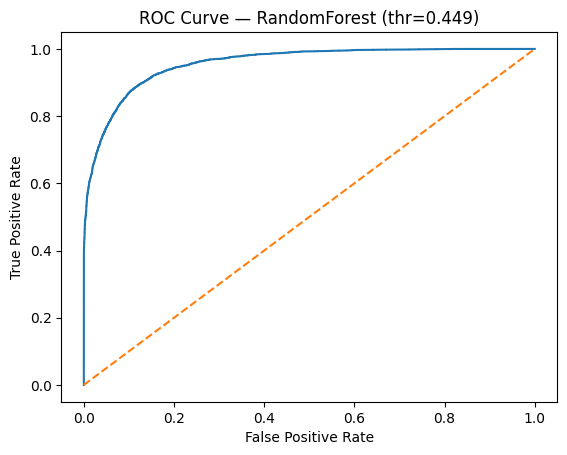

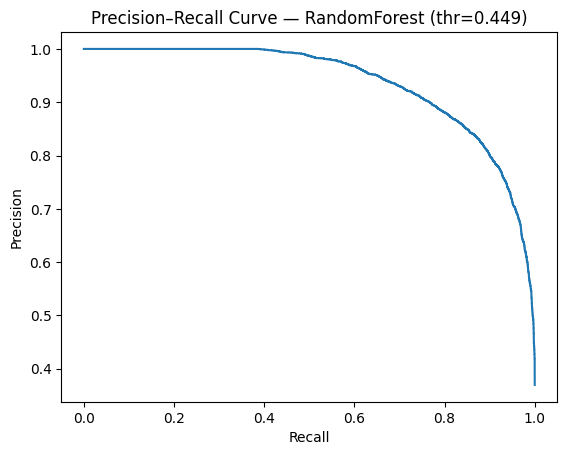

In [25]:
# === STEP 4 — Cell 4: ROC & PR Curves (Best Model) ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Pastikan kita punya proba & y_valid dari STEP 3
assert 'proba_best' in globals() and 'y_valid' in globals(), "Pastikan STEP 3 selesai."

# ROC
fpr, tpr, _ = roc_curve(y_valid, proba_best)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC Curve — {best_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y_valid, proba_best)
plt.figure()
plt.plot(rec, prec)
plt.title(f"Precision–Recall Curve — {best_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Best threshold by COST: 0.300  (min total cost = 3846.0)

Confusion Matrix @thr (cost-based):
[[8392 2111]
 [ 347 5809]]


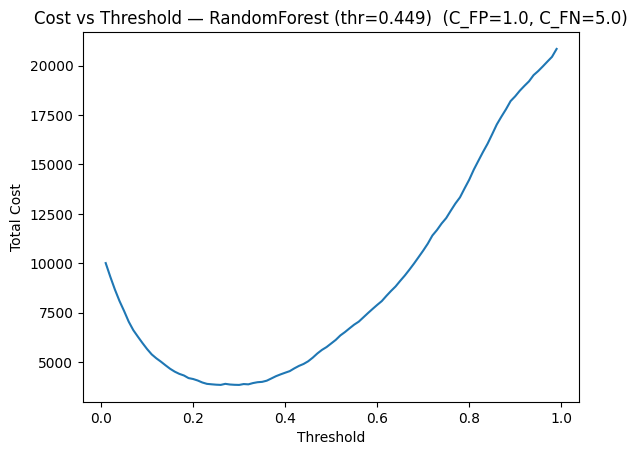

In [26]:
# === STEP 4 — Cell 5: Cost–Benefit Threshold Selection ===
# Definisikan biaya sesuai konteks bisnis:
# - C_FP: biaya salah menandai "akan cancel" padahal tidak (mis. effort follow-up, diskon tak perlu).
# - C_FN: biaya gagal mendeteksi cancel (lost revenue, wasted capacity).
C_FP = 1.0
C_FN = 5.0

# Sweep threshold & hitung total cost
ths = np.linspace(0.01, 0.99, 99)
costs = []
best_cost = None
best_thr_cost = None
best_cm = None

for t in ths:
    yhat = (proba_best >= t).astype(int)
    FP = ((yhat == 1) & (y_valid.values == 0)).sum()
    FN = ((yhat == 0) & (y_valid.values == 1)).sum()
    cost = C_FP*FP + C_FN*FN
    costs.append(cost)
    if best_cost is None or cost < best_cost:
        best_cost = cost
        best_thr_cost = t
        from sklearn.metrics import confusion_matrix
        best_cm = confusion_matrix(y_valid, yhat)

print(f"Best threshold by COST: {best_thr_cost:.3f}  (min total cost = {best_cost})")
print("\nConfusion Matrix @thr (cost-based):")
print(best_cm)

# Plot cost vs threshold
plt.figure()
plt.plot(ths, costs)
plt.title(f"Cost vs Threshold — {best_name}  (C_FP={C_FP}, C_FN={C_FN})")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.show()

In [27]:
# === STEP 4 — Cell 6: Save Artifacts (Optional) ===
import os, json, joblib
from datetime import datetime

out_dir = "artifacts"
os.makedirs(out_dir, exist_ok=True)

# Simpan pipeline terbaik
model_path = os.path.join(out_dir, "best_model.pkl")
joblib.dump(best_pipe, model_path)

# Simpan threshold hasil F1 & Cost
meta = {
    "best_model_name": best_name,
    "thr_f1": float(best_thr),
    "thr_cost": float(best_thr_cost) if 'best_thr_cost' in globals() else None,
    "roc_auc": float(best_res["roc"]),
    "pr_auc": float(best_res["pr"]),
    "timestamp": datetime.utcnow().isoformat() + "Z"
}
with open(os.path.join(out_dir, "model_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Artifacts saved to:", out_dir)
print(" -", model_path)
print(" -", os.path.join(out_dir, "model_meta.json"))

Artifacts saved to: artifacts
 - artifacts/best_model.pkl
 - artifacts/model_meta.json


/tmp/ipython-input-2907602798.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z"


In [28]:
# === STEP 5 — Cell 1: Utilities & Final Metrics Snapshot ===
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix

assert all(v in globals() for v in ["best_name","best_pipe","best_thr","proba_best","X_valid","y_valid","X_prepared","y"]), \
    "Pastikan STEP 3 & STEP 4 sudah dijalankan."

# Snapshot metrik pada threshold terpilih (F1-tuned dari STEP 3/4)
yhat_best = (proba_best >= best_thr).astype(int)
final_metrics = {
    "Model": best_name,
    "Threshold": float(best_thr),
    "ROC_AUC": float(roc_auc_score(y_valid, proba_best)),
    "PR_AUC": float(average_precision_score(y_valid, proba_best)),
    "F1": float(f1_score(y_valid, yhat_best)),
    "Precision": float(precision_score(y_valid, yhat_best, zero_division=0)),
    "Recall": float(recall_score(y_valid, yhat_best, zero_division=0)),
    "Confusion_Matrix": confusion_matrix(y_valid, yhat_best).tolist()
}
pd.DataFrame([final_metrics])

,Model,Threshold,ROC_AUC,PR_AUC,F1,Precision,Recall,Confusion_Matrix
0,RandomForest (thr=0.449),0.448802,0.956787,0.936871,0.852691,0.834968,0.871183,"[[9443, 1060], [793, 5363]]"


In [29]:
# === STEP 5 — Cell 2: Get Feature Names & Top Features ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def get_feature_names_from_ct(ct: ColumnTransformer):
    feat_names = []
    # numeric names
    for name, trans, cols in ct.transformers_:
        if name == "num":
            feat_names.extend(list(cols))
    # categorical OHE names
    for name, trans, cols in ct.transformers_:
        if name == "cat":
            try:
                ohe = trans.named_steps["oh"]
                feat_names.extend(ohe.get_feature_names_out(cols).tolist())
            except Exception:
                pass
    return feat_names

prep = best_pipe.named_steps["prep"]
feat_names = get_feature_names_from_ct(prep)

# Buat tabel top features tergantung tipe model
if "Logistic" in best_name:
    coefs = best_pipe.named_steps["clf"].coef_.ravel()
    top_df = pd.DataFrame({"feature": feat_names[:len(coefs)], "weight": coefs})
    top_df["abs_weight"] = top_df["weight"].abs()
    top_df["effect"] = np.where(top_df["weight"]>0, "increase_cancel_prob", "decrease_cancel_prob")
    top_df = top_df.sort_values("abs_weight", ascending=False).head(20)
elif "RandomForest" in best_name:
    imps = best_pipe.named_steps["clf"].feature_importances_
    top_df = pd.DataFrame({"feature": feat_names[:len(imps)], "weight": imps})
    top_df = top_df.sort_values("weight", ascending=False).head(20)
    top_df["effect"] = "unknown_non_linear"
else:
    top_df = pd.DataFrame({"feature": [], "weight": [], "effect": []})

top_df.reset_index(drop=True, inplace=True)
top_df

,feature,weight,effect
0,country_PRT,0.084876,unknown_non_linear
1,lead_time,0.083727,unknown_non_linear
2,deposit_type_Non Refund,0.071186,unknown_non_linear
3,total_of_special_requests,0.055590,unknown_non_linear
4,deposit_type_No Deposit,0.054776,unknown_non_linear
5,adr,0.037900,unknown_non_linear
6,room_changed,0.037785,unknown_non_linear
7,required_car_parking_spaces,0.029254,unknown_non_linear
8,bookingID,0.024630,unknown_non_linear
9,arrival_date_week_number,0.024200,unknown_non_linear


In [30]:
# === STEP 5 — Cell 3: Parse OHE names to original columns & types ===
# Heuristik: nama OHE biasanya "<col>_<category>". Kita ekstrak kolom aslinya.
orig_cols = X_prepared.columns.tolist()
orig_types = {c: str(X_prepared[c].dtype) for c in orig_cols}

def parse_original(feat):
    # Cari kolom asli yang merupakan prefix dari fitur OHE
    candidates = [c for c in orig_cols if feat.startswith(c + "_")]
    if candidates:
        return candidates[0]
    # Jika bukan OHE (fitur numeric asli)
    if feat in orig_cols:
        return feat
    # Fallback: coba split pertama
    return feat.split("_")[0]

top_df["orig_feature"] = top_df["feature"].apply(parse_original)
top_df["orig_dtype"] = top_df["orig_feature"].map(orig_types).fillna("unknown")
top_df

,feature,weight,effect,orig_feature,orig_dtype
0,country_PRT,0.084876,unknown_non_linear,country,object
1,lead_time,0.083727,unknown_non_linear,lead_time,int64
2,deposit_type_Non Refund,0.071186,unknown_non_linear,deposit_type,object
3,total_of_special_requests,0.055590,unknown_non_linear,total_of_special_requests,int64
4,deposit_type_No Deposit,0.054776,unknown_non_linear,deposit_type,object
5,adr,0.037900,unknown_non_linear,adr,float64
6,room_changed,0.037785,unknown_non_linear,room_changed,int64
7,required_car_parking_spaces,0.029254,unknown_non_linear,required_car_parking_spaces,int64
8,bookingID,0.024630,unknown_non_linear,bookingID,int64
9,arrival_date_week_number,0.024200,unknown_non_linear,arrival_date_week_number,int64


In [31]:
# === STEP 5 — Cell 4: Summaries for Top Features (numeric & categorical) ===
insights = []

def summarize_numeric(col):
    s = X_prepared[col]
    df_tmp = pd.DataFrame({"x": s, "y": y})
    grp = df_tmp.groupby("y")["x"].agg(["mean","median","std","min","max","count"])
    overall = s.describe()
    # perbedaan mean antara cancel(1) vs not(0)
    diff = grp.loc[1, "mean"] - grp.loc[0, "mean"] if 1 in grp.index and 0 in grp.index else np.nan
    return {
        "overall_mean": float(overall["mean"]),
        "overall_median": float(overall["50%"]),
        "mean_y1": float(grp.loc[1,"mean"]) if 1 in grp.index else np.nan,
        "mean_y0": float(grp.loc[0,"mean"]) if 0 in grp.index else np.nan,
        "mean_diff_1minus0": float(diff) if pd.notnull(diff) else np.nan
    }

def summarize_categorical(col, top_k=5):
    s = X_prepared[col].astype(str)
    df_tmp = pd.DataFrame({"x": s, "y": y})
    rate = df_tmp.groupby("x")["y"].mean().sort_values(ascending=False)
    cnt  = df_tmp["x"].value_counts()
    top_list = [(k, float(rate.loc[k]), int(cnt.loc[k])) for k in rate.index[:top_k]]
    bot_list = [(k, float(rate.loc[k]), int(cnt.loc[k])) for k in rate.index[-top_k:]]
    return {"top_cat_by_cancel_rate": top_list, "bottom_cat_by_cancel_rate": bot_list}

for _, row in top_df.iterrows():
    col = row["orig_feature"]
    if col in X_prepared.columns:
        if str(X_prepared[col].dtype) != "object":
            sm = summarize_numeric(col)
        else:
            sm = summarize_categorical(col, top_k=5)
        insights.append({
            "feature": row["feature"],
            "orig_feature": col,
            "dtype": str(X_prepared[col].dtype),
            "model_weight": float(row["weight"]),
            "model_effect": row["effect"],
            "summary": sm
        })

insight_df = pd.DataFrame(insights)
insight_df.head(10)

,feature,orig_feature,dtype,model_weight,model_effect,summary
0,country_PRT,country,object,0.084876,unknown_non_linear,"{'top_cat_by_cancel_rate': [('PRT', 0.56444392..."
1,lead_time,lead_time,int64,0.083727,unknown_non_linear,"{'overall_mean': 103.91423048755598, 'overall_..."
2,deposit_type_Non Refund,deposit_type,object,0.071186,unknown_non_linear,"{'top_cat_by_cancel_rate': [('Non Refund', 0.9..."
3,total_of_special_requests,total_of_special_requests,int64,0.055590,unknown_non_linear,"{'overall_mean': 0.5719448212935061, 'overall_..."
4,deposit_type_No Deposit,deposit_type,object,0.054776,unknown_non_linear,"{'top_cat_by_cancel_rate': [('Non Refund', 0.9..."
5,adr,adr,float64,0.037900,unknown_non_linear,"{'overall_mean': 101.39578980226432, 'overall_..."
6,room_changed,room_changed,int64,0.037785,unknown_non_linear,"{'overall_mean': 0.12505252542230438, 'overall..."
7,required_car_parking_spaces,required_car_parking_spaces,int64,0.029254,unknown_non_linear,"{'overall_mean': 0.061817919873218635, 'overal..."
8,bookingID,bookingID,int64,0.024630,unknown_non_linear,"{'overall_mean': 41647.0, 'overall_median': 41..."
9,arrival_date_week_number,arrival_date_week_number,int64,0.024200,unknown_non_linear,"{'overall_mean': 27.164023387319464, 'overall_..."


In [32]:
# === STEP 5 — Cell 5: Auto Recommendations (rule-based heuristics) ===
recs = []

# Helper untuk menambah rekomendasi unik
def add_rec(topic, action, why):
    recs.append({"topic": topic, "action": action, "why": why})

# Contoh domain rules umum pada hotel booking:
present_feats = set(top_df["orig_feature"].unique())

if "lead_time" in present_feats:
    add_rec("Lead time",
            "Prioritaskan reminder & penawaran fleksibel untuk booking dengan lead_time sangat panjang.",
            "Lead_time tinggi cenderung meningkatkan risiko cancel; intervensi awal bisa menurunkan niat batal.")

if "deposit_type" in present_feats:
    add_rec("Deposit policy",
            "Uji kebijakan deposit/garansi berbeda untuk segmen berisiko tinggi (A/B policy).",
            "Kebijakan deposit memengaruhi komitmen pelanggan dan menurunkan pembatalan oportunistik.")

if "previous_cancellations" in present_feats:
    add_rec("Repeat behavior",
            "Terapkan verifikasi / friction ringan untuk akun dengan riwayat pembatalan berulang.",
            "Riwayat pembatalan adalah sinyal kuat perilaku; kontrol ringan mengurangi kerugian.")

if "market_segment" in present_feats or "distribution_channel" in present_feats:
    add_rec("Segment/channel management",
            "Optimalkan alokasi kuota & kebijakan per segmen/channel dengan cancel-rate tinggi.",
            "Beberapa segmen/channel memiliki profil pembatalan berbeda → perlakukan berbeda.")

if "assigned_room_type" in present_feats or "reserved_room_type" in present_feats or "room_changed" in present_feats:
    add_rec("Inventory/room assignment",
            "Minimalkan gap 'reserved vs assigned' untuk segmen berisiko; siapkan fallback konsisten.",
            "Perubahan tipe kamar berkaitan dengan pengalaman & ekspektasi; bisa memicu pembatalan.")

if "adr" in present_feats:
    add_rec("Pricing",
            "Monitor cancel-rate pada rentang ADR tertentu; bundle benefit (refundable/minimal penalty) di rentang berisiko.",
            "Harga ekstrem sering memicu pembatalan; kombinasi harga–kebijakan bisa menurunkan risiko.")

if "total_guests" in present_feats:
    add_rec("Party size",
            "Sediakan opsi fleksibilitas (mis. perubahan jumlah tamu) untuk grup ukuran tertentu.",
            "Ukuran grup berkorelasi dengan kompleksitas rencana, mempengaruhi pembatalan.")

# Fallback: jika tidak ada rule spesifik terpicu, berikan rekomendasi umum
if len(recs) == 0:
    add_rec("General",
            "Fokus pada top 5 fitur menurut model; jalankan eksperimen kecil per faktor.",
            "Mengatasi faktor terbesar memberi dampak tercepat pada cancel-rate.")

recs_df = pd.DataFrame(recs)
recs_df

,topic,action,why
0,Lead time,Prioritaskan reminder & penawaran fleksibel un...,Lead_time tinggi cenderung meningkatkan risiko...
1,Deposit policy,Uji kebijakan deposit/garansi berbeda untuk se...,Kebijakan deposit memengaruhi komitmen pelangg...
2,Repeat behavior,Terapkan verifikasi / friction ringan untuk ak...,Riwayat pembatalan adalah sinyal kuat perilaku...
3,Segment/channel management,Optimalkan alokasi kuota & kebijakan per segme...,Beberapa segmen/channel memiliki profil pembat...
4,Inventory/room assignment,Minimalkan gap 'reserved vs assigned' untuk se...,Perubahan tipe kamar berkaitan dengan pengalam...
5,Pricing,Monitor cancel-rate pada rentang ADR tertentu;...,Harga ekstrem sering memicu pembatalan; kombin...


In [33]:
# === STEP 5 — Cell 6: Generate Markdown Report & Slide Outline ===
import os, json
from datetime import datetime

out_dir = "artifacts"
os.makedirs(out_dir, exist_ok=True)

# 1) Markdown report (insight + rekomendasi)
report_lines = []
report_lines.append(f"# Final Insight Report — {best_name}")
report_lines.append(f"_Generated: {datetime.utcnow().isoformat()}Z_")
report_lines.append("")
report_lines.append("## A. Final Metrics")
for k in ["Model","Threshold","ROC_AUC","PR_AUC","F1","Precision","Recall"]:
    report_lines.append(f"- **{k}**: {final_metrics[k]}")
report_lines.append("")
report_lines.append("**Confusion Matrix (tn, fp; fn, tp)**:")
report_lines.append(f"`{final_metrics['Confusion_Matrix']}`")
report_lines.append("")
report_lines.append("## B. Top Features")
report_lines.append(top_df.to_markdown(index=False))
report_lines.append("")
report_lines.append("## C. Feature Insights (sample)")
report_lines.append(insight_df.head(10).to_markdown(index=False))
report_lines.append("")
report_lines.append("## D. Recommendations")
if len(recs) > 0:
    for r in recs:
        report_lines.append(f"- **{r['topic']}** — {r['action']} _(alasan: {r['why']})_")
else:
    report_lines.append("- (No specific recommendations generated.)")
report_lines.append("")
report_lines.append("## E. Next Steps")
report_lines.append("- Pilih threshold operasional (F1 atau cost-based) → implement SOP aksi.")
report_lines.append("- Lakukan A/B test pada 1–2 kebijakan paling relevan (deposit, reminder, pricing).")
report_lines.append("- Monitoring bulanan: drift data, decay performa, dan audit fairness by segment.")

report_path = os.path.join(out_dir, "final_insight_report.md")
with open(report_path, "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

# 2) Slide outline (untuk presentasi)
slides = []
slides.append("# Slide Outline — Study Case Cancellation Prediction")
slides.append("1. Title & Business Context")
slides.append("2. Problem Statement & Goal (metric bisnis + metric teknis)")
slides.append("3. Data Overview & Quality (missing, dupe, leakage)")
slides.append("4. Descriptive & Diagnostic Insights (grafik kunci)")
slides.append("5. Modelling: Baseline vs Candidate + Validasi")
slides.append("6. Best Model & Operating Threshold (F1/cost)")
slides.append("7. Explainability (Top Features + contoh kasus)")
slides.append("8. Business Impact Simulation (cost–benefit)")
slides.append("9. Recommendations & 4–12 Week Roadmap")
slides.append("10. Risk & Monitoring (drift, fairness, fallback)")
slides_path = os.path.join(out_dir, "slide_outline.md")
with open(slides_path, "w", encoding="utf-8") as f:
    f.write("\n".join(slides))

print("Saved:")
print("-", report_path)
print("-", slides_path)

Saved:
- artifacts/final_insight_report.md
- artifacts/slide_outline.md


/tmp/ipython-input-3977360092.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  report_lines.append(f"_Generated: {datetime.utcnow().isoformat()}Z_")


In [34]:
# === STEP 5 — Cell 7 (Optional): Export Tables to CSV ===
top_features_csv = os.path.join("artifacts", "top_features.csv")
insight_csv      = os.path.join("artifacts", "feature_insights_sample.csv")
recs_csv         = os.path.join("artifacts", "recommendations.csv")

top_df.to_csv(top_features_csv, index=False)
insight_df.to_csv(insight_csv, index=False)
pd.DataFrame(recs).to_csv(recs_csv, index=False)

print("Exported CSVs:")
print("-", top_features_csv)
print("-", insight_csv)
print("-", recs_csv)

Exported CSVs:
- artifacts/top_features.csv
- artifacts/feature_insights_sample.csv
- artifacts/recommendations.csv


In [35]:
# === STEP 6 — Cell 1: Save Monitoring Baseline (from training) ===
import os, json, numpy as np, pandas as pd

assert 'X_train' in globals(), "Butuh X_train dari STEP 3."

out_dir = "artifacts"
os.makedirs(out_dir, exist_ok=True)

baseline = {"numeric": {}, "categorical": {}, "notes": {}}

# 1) Numeric: simpan bin (quantile) & distribusi training (untuk PSI)
num_cols_mon = X_train.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_mon:
    s = pd.to_numeric(X_train[c], errors="coerce")
    # gunakan quantile bins agar robust terhadap skala
    qs = np.linspace(0, 1, 11)
    edges = s.quantile(qs).values
    # pastikan tepi unik & urut
    edges = np.unique(edges)
    if len(edges) < 3:  # terlalu sedikit variasi
        continue
    hist, _ = np.histogram(s.dropna(), bins=edges)
    probs = (hist / hist.sum()).tolist()
    baseline["numeric"][c] = {
        "bin_edges": edges.tolist(),
        "probs": probs,
        "mean": float(s.mean()),
        "std": float(s.std())
    }

# 2) Categorical: simpan frekuensi (top-N) + 'Other'
cat_cols_mon = X_train.select_dtypes(include=["object"]).columns.tolist()
TOPK = 20
for c in cat_cols_mon:
    vc = X_train[c].astype(str).value_counts()
    total = vc.sum()
    top = vc.head(TOPK)
    other = total - top.sum()
    freqs = {k: float(v/total) for k, v in top.items()}
    if other > 0:
        freqs["__OTHER__"] = float(other/total)
    baseline["categorical"][c] = {"freqs": freqs, "topk": TOPK}

# 3) Simpan juga batas winsor untuk 'adr' (dipakai saat scoring agar konsisten)
if "adr" in X_train.columns:
    lo, hi = X_train["adr"].quantile([0.01, 0.99])
    baseline["notes"]["adr_clip"] = {"lo": float(lo), "hi": float(hi)}

baseline_path = os.path.join(out_dir, "monitor_baseline.json")
with open(baseline_path, "w") as f:
    json.dump(baseline, f, indent=2)

print("Monitoring baseline saved to:", baseline_path)
print("Numeric refs:", len(baseline["numeric"]), "| Categorical refs:", len(baseline["categorical"]))

Monitoring baseline saved to: artifacts/monitor_baseline.json
Numeric refs: 14 | Categorical refs: 11


In [36]:
# === STEP 6 — Cell 2: Prepare Function for New Batch ===
import calendar

def prepare_new_batch(df_raw: pd.DataFrame, baseline_path="artifacts/monitor_baseline.json") -> pd.DataFrame:
    """
    Menerapkan treatment STEP 2 untuk data baru:
    - drop leakage (reservation_status*)
    - normalisasi ID (agent/company -> string), country uppercase
    - feature engineering: stays_total_nights, total_guests, room_changed, arrival_month_num
    - winsor 'adr' memakai batas training (jika tersedia di baseline)
    """
    dfp = df_raw.copy()

    # Drop leakage jika ada
    for c in ["reservation_status", "reservation_status_date"]:
        if c in dfp.columns:
            dfp.drop(columns=[c], inplace=True)

    # ID numerik -> string
    for id_like in ["agent","company"]:
        if id_like in dfp.columns:
            dfp[id_like] = (dfp[id_like]
                            .fillna(-1)
                            .astype(float)
                            .astype(int)
                            .astype(str))

    # Normalisasi contoh
    if "country" in dfp.columns and dfp["country"].dtype == "object":
        dfp["country"] = dfp["country"].str.upper()

    # Feature engineering
    if set(["stays_in_weekend_nights","stays_in_week_nights"]).issubset(dfp.columns):
        dfp["stays_total_nights"] = dfp["stays_in_weekend_nights"].fillna(0) + dfp["stays_in_week_nights"].fillna(0)

    for col in ["adults","children","babies"]:
        if col in dfp.columns:
            dfp[col] = dfp[col].fillna(0)
    if set(["adults","children","babies"]).issubset(dfp.columns):
        dfp["total_guests"] = dfp["adults"] + dfp["children"] + dfp["babies"]

    if set(["reserved_room_type","assigned_room_type"]).issubset(dfp.columns):
        dfp["room_changed"] = (dfp["reserved_room_type"].astype(str) != dfp["assigned_room_type"].astype(str)).astype(int)

    if "arrival_date_month" in dfp.columns:
        s = dfp["arrival_date_month"].dropna().astype(str)
        if len(s) and s.str.len().max() <= 3:
            month_map = {m[:3]:i for i,m in enumerate(calendar.month_name) if m}
        else:
            month_map = {m:i for i,m in enumerate(calendar.month_name) if m}
        dfp["arrival_month_num"] = dfp["arrival_date_month"].astype(str).map(month_map)

    # Winsor ADR (pakai batas training agar konsisten)
    try:
        with open(baseline_path, "r") as f:
            base = json.load(f)
        if "adr" in dfp.columns and "adr_clip" in base.get("notes", {}):
            lo = base["notes"]["adr_clip"]["lo"]
            hi = base["notes"]["adr_clip"]["hi"]
            dfp.loc[dfp["adr"] < 0, "adr"] = 0
            dfp["adr"] = dfp["adr"].clip(lower=lo, upper=hi)
    except Exception:
        # kalau baseline belum ada, tetap lanjut (imputer di pipeline akan menangani missing)
        pass

    return dfp

In [37]:
# === STEP 6 — Cell 3: Batch Scoring Function (SAFE) ===
import os, json, joblib
import numpy as np, pandas as pd

def load_model_and_meta(model_path="artifacts/best_model.pkl", meta_path="artifacts/model_meta.json"):
    model, meta = None, {}
    if os.path.exists(model_path):
        try:
            model = joblib.load(model_path)
        except Exception:
            model = None
    if os.path.exists(meta_path):
        try:
            with open(meta_path, "r") as f:
                meta = json.load(f)
        except Exception:
            meta = {}
    return model, meta

def _expected_cols_from_model(model):
    """Ambil daftar kolom numeric & categorical yang diharapkan ColumnTransformer."""
    num_cols_expected, cat_cols_expected = [], []
    prep = model.named_steps.get("prep", None)
    if prep is None:
        return num_cols_expected, cat_cols_expected
    for name, trans, cols in prep.transformers_:
        if name == "num":
            num_cols_expected = list(cols)
        elif name == "cat":
            cat_cols_expected = list(cols)
    return num_cols_expected, cat_cols_expected

def score_batch(df_raw: pd.DataFrame,
                model_path="artifacts/best_model.pkl",
                meta_path="artifacts/model_meta.json",
                threshold: float | None = None,
                already_prepared: bool = False) -> pd.DataFrame:
    """
    Scoring aman:
    - Jika already_prepared=False -> apply prepare_new_batch (mirip STEP 2).
    - Selaraskan tipe & kolom sesuai yang diharapkan model:
        * kolom numeric -> coerce ke numeric (errors='coerce')
        * kolom hilang -> tambahkan sebagai NaN agar imputer bisa bekerja
    """
    # 1) Load model & meta (fallback ke objek memori)
    model, meta = load_model_and_meta(model_path, meta_path)
    if model is None:
        assert 'best_pipe' in globals(), "Model artifact tidak ditemukan dan best_pipe tidak tersedia."
        model = best_pipe

    # 2) Siapkan data
    dfp = df_raw.copy() if already_prepared else prepare_new_batch(df_raw)

    # 3) Selaraskan kolom & tipe sesuai yang diharapkan model
    num_expected, cat_expected = _expected_cols_from_model(model)

    # Tambahkan kolom yang hilang sebagai NaN
    for c in num_expected:
        if c not in dfp.columns:
            dfp[c] = np.nan
    for c in cat_expected:
        if c not in dfp.columns:
            dfp[c] = np.nan

    # Coerce numeric expected columns menjadi numeric
    for c in num_expected:
        dfp[c] = pd.to_numeric(dfp[c], errors="coerce")

    # (Catatan: kolom lain diabaikan oleh ColumnTransformer)

    # 4) Threshold
    thr = threshold
    if thr is None:
        thr = meta.get("thr_cost") or meta.get("thr_f1") or (best_thr if 'best_thr' in globals() else 0.5)
    thr = float(thr)

    # 5) Skor
    proba = model.predict_proba(dfp)[:, 1]
    pred  = (proba >= thr).astype(int)

    out = dfp.copy()
    out["score_proba"] = proba
    out["pred_label"] = pred
    out.attrs["threshold"] = thr
    return out

In [38]:
# === STEP 6 — Cell 4: Example Scoring on Validation Set (PREPARED DATA) ===
assert 'X_valid' in globals(), "Butuh X_valid dari STEP 3."

# Karena X_valid sudah diprepare (hasil STEP 2/3), set already_prepared=True
scored_valid = score_batch(X_valid, already_prepared=True)

display(scored_valid.head(3)[["score_proba","pred_label"]])

# Simpan ke CSV untuk contoh batch output
import os
os.makedirs("artifacts", exist_ok=True)
scored_path = "artifacts/scored_validation.csv"
scored_valid.to_csv(scored_path, index=False)
print("Saved scored batch to:", scored_path)

,score_proba,pred_label
45716,0.436031,1
82387,0.455321,1
74068,0.458117,1


Saved scored batch to: artifacts/scored_validation.csv


In [39]:
# === STEP 7 — Cell 1: Operating Threshold & Final Predictions ===
import numpy as np

thr_op = None
if 'best_thr_cost' in globals() and best_thr_cost is not None:
    thr_op = float(best_thr_cost)
elif 'best_thr' in globals():
    thr_op = float(best_thr)
else:
    thr_op = 0.5  # fallback aman

assert 'proba_best' in globals() and 'y_valid' in globals() and 'X_valid' in globals(), \
    "Pastikan STEP 3–4 sudah dijalankan (proba_best, y_valid, X_valid)."

yhat_op = (proba_best >= thr_op).astype(int)

print(f"Operating threshold dipakai: {thr_op:.3f}")
print("Pred sample:", yhat_op[:10])

Operating threshold dipakai: 0.300
Pred sample: [1 1 1 0 0 0 0 0 0 1]


In [40]:
# === STEP 7 — Cell 2: Segment Evaluation Helpers ===
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def safe_metrics(y_true, y_pred, y_proba=None):
    """Hitung metrik inti dengan zero_division aman & guard untuk ROC/PR bila kelas tunggal."""
    out = {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }
    # ROC/PR-AUC hanya bermakna jika ada 1 dan 0 di y_true
    if y_proba is not None and len(set(y_true)) > 1:
        out["roc_auc"] = roc_auc_score(y_true, y_proba)
        out["pr_auc"]  = average_precision_score(y_true, y_proba)
    else:
        out["roc_auc"] = float("nan")
        out["pr_auc"]  = float("nan")
    return out

def evaluate_by_segment(X, y_true, y_pred, y_proba, column, min_count=100, topN=None):
    """
    Hitung metrik per nilai kategori di kolom 'column'.
    - min_count: grup dengan N < min_count di-skip agar stabil.
    - topN: kalau kolom punya nilai sangat banyak (e.g., country), ambil topN by size.
    """
    df_seg = pd.DataFrame({"group": X[column].astype(str), "y": y_true, "pred": y_pred})
    if y_proba is not None:
        df_seg["proba"] = y_proba
    size = df_seg["group"].value_counts()
    groups = size.index.tolist()

    # pilih topN terbesar jika diminta
    if topN is not None and len(groups) > topN:
        groups = size.head(topN).index.tolist()

    rows = []
    for g in groups:
        idx = (df_seg["group"] == g)
        n = int(idx.sum())
        if n < min_count:
            continue
        y_g   = df_seg.loc[idx, "y"].to_numpy()
        pred_g= df_seg.loc[idx, "pred"].to_numpy()
        proba_g = df_seg.loc[idx, "proba"].to_numpy() if "proba" in df_seg.columns else None

        met = safe_metrics(y_g, pred_g, proba_g)
        rows.append({
            "segment_col": column,
            "segment_val": g,
            "count": n,
            "pos_rate": float(y_g.mean()) if n>0 else float("nan"),
            **met
        })
    return pd.DataFrame(rows).sort_values(["segment_col","count"], ascending=[True,False]).reset_index(drop=True)

def bin_numeric_series(s, q=[0, .2, .4, .6, .8, 1.0], prefix="bin"):
    """Binning kuantil untuk numerik agar bisa dievaluasi seperti kategori."""
    try:
        cats = pd.qcut(s, q=q, duplicated="drop")
        return cats.astype(str).fillna("NaN")
    except Exception:
        # fallback jika nilai unik sedikit atau qcut gagal
        return pd.cut(s, bins=min(5, max(2, s.nunique())), duplicates="drop").astype(str).fillna("NaN")

In [41]:
# === STEP 7 — Cell 3: Segment List & Evaluation ===
seg_cols_cat = [c for c in ["hotel","market_segment","distribution_channel","deposit_type",
                            "customer_type","country","reserved_room_type","assigned_room_type"]
                if c in X_valid.columns]

# Tambah bins untuk numerik penting (jika ada)
Xv_seg = X_valid.copy()
num_bins_cfg = []
if "lead_time" in Xv_seg.columns:
    Xv_seg["lead_time_bin"] = bin_numeric_series(pd.to_numeric(Xv_seg["lead_time"], errors="coerce"),
                                                 q=[0,.25,.5,.75,1.0], prefix="lead")
    num_bins_cfg.append("lead_time_bin")
if "adr" in Xv_seg.columns:
    Xv_seg["adr_bin"] = bin_numeric_series(pd.to_numeric(Xv_seg["adr"], errors="coerce"),
                                           q=[0,.25,.5,.75,1.0], prefix="adr")
    num_bins_cfg.append("adr_bin")
if "stays_total_nights" in Xv_seg.columns:
    Xv_seg["stays_bin"] = bin_numeric_series(pd.to_numeric(Xv_seg["stays_total_nights"], errors="coerce"),
                                             q=[0,.25,.5,.75,1.0], prefix="stays")
    num_bins_cfg.append("stays_bin")

seg_cols_all = seg_cols_cat + num_bins_cfg
print("Segment columns:", seg_cols_all)

# Evaluasi semua kolom
all_reports = []
for col in seg_cols_all:
    # untuk country biasanya ambil top 15 biar ringkas
    topN = 15 if col == "country" else None
    rep = evaluate_by_segment(Xv_seg, y_valid.to_numpy(), yhat_op, proba_best, col,
                              min_count=100, topN=topN)
    if not rep.empty:
        all_reports.append(rep)

seg_report = pd.concat(all_reports, axis=0).reset_index(drop=True) if len(all_reports)>0 else pd.DataFrame()
display(seg_report.head(20))
print("Total segment rows:", seg_report.shape)

Segment columns: ['hotel', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type', 'country', 'reserved_room_type', 'assigned_room_type', 'lead_time_bin', 'adr_bin', 'stays_bin']


,segment_col,segment_val,count,pos_rate,precision,recall,f1,roc_auc,pr_auc
0,hotel,"Sheraton Lima Hotel & Convention Center Lima, ...",295,0.386441,0.739437,0.921053,0.820312,0.938645,0.926413
1,hotel,"Crystal Cove, Barbados Barbados",287,0.337979,0.733333,0.907216,0.811060,0.963429,0.938946
2,hotel,Renaissance New York Times Square Hotel New Yo...,286,0.363636,0.720588,0.942308,0.816667,0.955251,0.931233
3,hotel,Baton Rouge Acadian Centre/LSU Area Courtyard ...,281,0.352313,0.696296,0.949495,0.803419,0.944278,0.916738
4,hotel,"Hotel Alfonso XIII, a Luxury Collection Hotel,...",280,0.353571,0.712121,0.949495,0.813853,0.959429,0.935437
5,hotel,"Chicago O'Hare Courtyard Des Plaines, IL",279,0.376344,0.792308,0.980952,0.876596,0.975534,0.961418
6,hotel,"Baltimore BWI Airport Courtyard Linthicum, MD",277,0.389892,0.718310,0.944444,0.816000,0.946581,0.929641
7,hotel,"Greensboro Courtyard Greensboro, NC",277,0.328520,0.726496,0.934066,0.817308,0.950431,0.926290
8,hotel,"Indianapolis Airport Courtyard Indianapolis, IN",275,0.352727,0.708661,0.927835,0.803571,0.954477,0.927003
9,hotel,"Albuquerque Airport Courtyard Albuquerque, NM",274,0.357664,0.714286,0.918367,0.803571,0.951878,0.928868


Total segment rows: (118, 9)


In [42]:
# === STEP 7 — Cell 4: Disparity vs Overall ===
from sklearn.metrics import precision_score, recall_score, f1_score

overall = {
    "precision": precision_score(y_valid, yhat_op, zero_division=0),
    "recall":    recall_score(y_valid, yhat_op, zero_division=0),
    "f1":        f1_score(y_valid, yhat_op, zero_division=0),
}
print("Overall (operational threshold):", overall)

def add_disparity(df, metric, overall_val):
    df = df.copy()
    df[f"{metric}_gap"] = df[metric] - overall_val
    df[f"{metric}_ratio"] = df[metric] / overall_val if overall_val>0 else np.nan
    return df

if not seg_report.empty:
    dis = seg_report.copy()
    for m in ["precision","recall","f1"]:
        dis = add_disparity(dis, m, overall[m])
    # Prioritaskan disparitas recall (sensitif untuk miss-cancel)
    dis_sorted = dis.sort_values(["segment_col","recall_gap"], ascending=[True, True]).reset_index(drop=True)
    display(dis_sorted.head(20))
else:
    print("Segment report kosong (mungkin semua grup < min_count).")

Overall (operational threshold): {'precision': 0.733459595959596, 'recall': 0.943632228719948, 'f1': 0.8253765274225632}


,segment_col,segment_val,count,pos_rate,precision,recall,f1,roc_auc,pr_auc,precision_gap,precision_ratio,recall_gap,recall_ratio,f1_gap,f1_ratio
0,adr_bin,"(-0.252, 50.4]",1739,0.225417,0.780430,0.834184,0.806412,0.951464,0.906618,0.046970,1.064039,-0.109449,0.884014,-0.018965,0.977023
1,adr_bin,"(151.2, 201.6]",1534,0.380704,0.647059,0.941781,0.767085,0.921287,0.880851,-0.086401,0.882201,-0.001851,0.998038,-0.058291,0.929376
2,adr_bin,"(100.8, 151.2]",4959,0.388990,0.692541,0.948160,0.800438,0.941065,0.915827,-0.040919,0.944211,0.004527,1.004798,-0.024939,0.969785
3,adr_bin,"(201.6, 252.0]",606,0.386139,0.625352,0.948718,0.753820,0.891485,0.816659,-0.108107,0.852606,0.005086,1.005390,-0.071556,0.913304
4,adr_bin,"(50.4, 100.8]",7821,0.385756,0.788235,0.954922,0.863609,0.972416,0.962913,0.054776,1.074681,0.011290,1.011964,0.038233,1.046321
5,assigned_room_type,B,338,0.236686,0.630000,0.787500,0.700000,0.910562,0.809331,-0.103460,0.858943,-0.156132,0.834541,-0.125377,0.848098
6,assigned_room_type,F,481,0.239085,0.612500,0.852174,0.712727,0.905607,0.699582,-0.120960,0.835083,-0.091458,0.903078,-0.112649,0.863518
7,assigned_room_type,C,355,0.152113,0.691176,0.870370,0.770492,0.968500,0.887036,-0.042283,0.942351,-0.073262,0.922362,-0.054885,0.933503
8,assigned_room_type,E,1067,0.270853,0.713499,0.896194,0.794479,0.946958,0.880487,-0.019961,0.972785,-0.047438,0.949728,-0.030898,0.962565
9,assigned_room_type,D,3556,0.260405,0.638282,0.914687,0.751886,0.936063,0.845100,-0.095178,0.870234,-0.028945,0.969326,-0.073490,0.910962


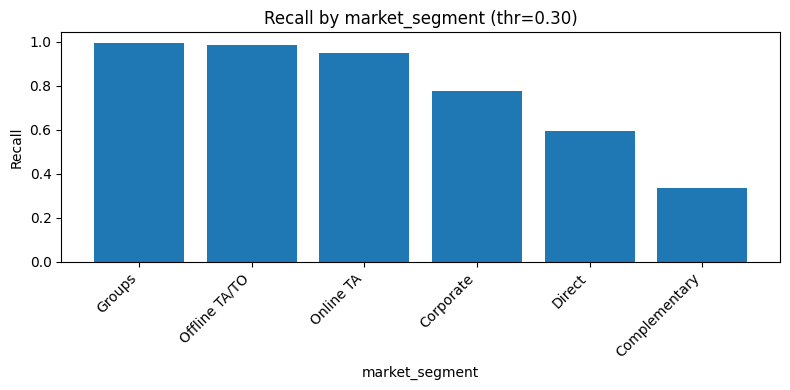

In [43]:
# === STEP 7 — Cell 5: Quick Plot (Recall by Group) ===
import matplotlib.pyplot as plt

col_to_plot = None
for c in ["market_segment","distribution_channel","deposit_type","country","lead_time_bin"]:
    if c in Xv_seg.columns:
        col_to_plot = c
        break

if col_to_plot and not seg_report.empty:
    toplot = seg_report[seg_report["segment_col"] == col_to_plot].sort_values("recall", ascending=False)
    plt.figure(figsize=(8,4))
    plt.bar(toplot["segment_val"].astype(str), toplot["recall"].values)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Recall by {col_to_plot} (thr={thr_op:.2f})")
    plt.xlabel(col_to_plot)
    plt.ylabel("Recall")
    plt.tight_layout()
    plt.show()
else:
    print("Kolom untuk plot tidak ditemukan atau seg_report kosong.")

In [44]:
# === STEP 7 — Cell 6: Action Heuristics per Segment ===
actions = []
if not seg_report.empty:
    # ambil 10 grup terburuk berdasarkan recall (gap paling negatif)
    dis_pick = dis_sorted.groupby("segment_col").head(10)
    for _, r in dis_pick.iterrows():
        why = []
        if r["recall_gap"] < -0.05:
            why.append(f"recall lebih rendah {abs(r['recall_gap']):.2f} dari overall")
        if r["pos_rate"] > seg_report["pos_rate"].median():
            why.append("cancel-rate grup di atas median")

        # contoh rekomendasi rule-of-thumb:
        if r["segment_col"] in ["market_segment","distribution_channel"]:
            act = "Tuning SOP follow-up / penawaran fleksibel untuk segmen/channel ini."
        elif r["segment_col"] in ["deposit_type"]:
            act = "Uji varian kebijakan deposit / refundable untuk segmen ini."
        elif r["segment_col"] in ["country"]:
            act = "Optimalkan komunikasi lokal (bahasa/jam) untuk negara ini."
        elif r["segment_col"].endswith("_bin"):
            act = "Sesuaikan threshold / workflow pada rentang numerik ini."
        else:
            act = "Investigasi penyebab & sesuaikan threshold/SOP segmen."

        actions.append({
            "segment_col": r["segment_col"],
            "segment_val": r["segment_val"],
            "count": int(r["count"]),
            "pos_rate": round(r["pos_rate"],4),
            "recall": round(r["recall"],4),
            "recommendation": act,
            "why": "; ".join(why) if why else "Performa di bawah keseluruhan."
        })

actions_df = pd.DataFrame(actions)
display(actions_df.head(20))

,segment_col,segment_val,count,pos_rate,recall,recommendation,why
0,adr_bin,"(-0.252, 50.4]",1739,0.2254,0.8342,Sesuaikan threshold / workflow pada rentang nu...,recall lebih rendah 0.11 dari overall
1,adr_bin,"(151.2, 201.6]",1534,0.3807,0.9418,Sesuaikan threshold / workflow pada rentang nu...,cancel-rate grup di atas median
2,adr_bin,"(100.8, 151.2]",4959,0.3890,0.9482,Sesuaikan threshold / workflow pada rentang nu...,cancel-rate grup di atas median
3,adr_bin,"(201.6, 252.0]",606,0.3861,0.9487,Sesuaikan threshold / workflow pada rentang nu...,cancel-rate grup di atas median
4,adr_bin,"(50.4, 100.8]",7821,0.3858,0.9549,Sesuaikan threshold / workflow pada rentang nu...,cancel-rate grup di atas median
5,assigned_room_type,B,338,0.2367,0.7875,Investigasi penyebab & sesuaikan threshold/SOP...,recall lebih rendah 0.16 dari overall
6,assigned_room_type,F,481,0.2391,0.8522,Investigasi penyebab & sesuaikan threshold/SOP...,recall lebih rendah 0.09 dari overall
7,assigned_room_type,C,355,0.1521,0.8704,Investigasi penyebab & sesuaikan threshold/SOP...,recall lebih rendah 0.07 dari overall
8,assigned_room_type,E,1067,0.2709,0.8962,Investigasi penyebab & sesuaikan threshold/SOP...,Performa di bawah keseluruhan.
9,assigned_room_type,D,3556,0.2604,0.9147,Investigasi penyebab & sesuaikan threshold/SOP...,Performa di bawah keseluruhan.


In [45]:
# === STEP 7 — Cell 7: Save Segment Reports ===
import os
os.makedirs("artifacts", exist_ok=True)

seg_path = "artifacts/segment_report.csv"
dis_path = "artifacts/segment_disparity.csv"
act_path = "artifacts/segment_actions.csv"

if not seg_report.empty:
    seg_report.to_csv(seg_path, index=False)
    dis_sorted.to_csv(dis_path, index=False)
if not actions_df.empty:
    actions_df.to_csv(act_path, index=False)

print("Saved:")
if not seg_report.empty: print("-", seg_path, "\n-", dis_path)
if not actions_df.empty: print("-", act_path)

Saved:
- artifacts/segment_report.csv 
- artifacts/segment_disparity.csv
- artifacts/segment_actions.csv


In [46]:
# === STEP 7 — Cell 8: Final Implementation Checklist ===
checklist = """
FINAL IMPLEMENTATION CHECKLIST
1) Operating threshold:
   - Dipakai: {:.3f} (cost-based jika ada, else F1-based).
   - Simpan di config layanan scoring.

2) Pipeline konsisten:
   - Pastikan fungsi prepare_new_batch diterapkan sebelum predict_proba.
   - Pastikan OHE handle_unknown='ignore' aktif (sudah di pipeline).

3) Monitoring:
   - Jalankan scoring batch harian/mingguan -> simpan skor & input ringkas.
   - Drift: gunakan artifacts/monitor_baseline.json + PSI report (Cell 5 Step 6).
   - Performance: hitung metrik saat ground-truth tersedia (Cell 6 Step 6).

4) SOP Aksi:
   - Definisikan tindakan untuk pred=1 (at-risk) dan pred=0.
   - Tulis SLA, kanal notifikasi, siapa PIC.

5) A/B Test:
   - Pilih 1–2 rekomendasi paling kuat dari actions_df.
   - Tentukan durasi & metrik sukses (cancel-rate turun, revenue naik, SLA tepat).

6) Governance:
   - Catat versi model (artifacts/best_model.pkl) & meta (threshold, tanggal).
   - Rencana retrain (mis. tiap 1–3 bulan) atau saat PSI > 0.25 pada fitur kunci.

7) Fairness & Compliance:
   - Tinjau disparity recall/precision antar segmen utama.
   - Tindakan mitigasi: threshold per-segmen (jika diperbolehkan), reweight, atau SOP tambahan.
""".format(thr_op)
print(checklist)


FINAL IMPLEMENTATION CHECKLIST
1) Operating threshold:
   - Dipakai: 0.300 (cost-based jika ada, else F1-based).
   - Simpan di config layanan scoring.

2) Pipeline konsisten:
   - Pastikan fungsi prepare_new_batch diterapkan sebelum predict_proba.
   - Pastikan OHE handle_unknown='ignore' aktif (sudah di pipeline).

3) Monitoring:
   - Jalankan scoring batch harian/mingguan -> simpan skor & input ringkas.
   - Drift: gunakan artifacts/monitor_baseline.json + PSI report (Cell 5 Step 6).
   - Performance: hitung metrik saat ground-truth tersedia (Cell 6 Step 6).

4) SOP Aksi:
   - Definisikan tindakan untuk pred=1 (at-risk) dan pred=0.
   - Tulis SLA, kanal notifikasi, siapa PIC.

5) A/B Test:
   - Pilih 1–2 rekomendasi paling kuat dari actions_df.
   - Tentukan durasi & metrik sukses (cancel-rate turun, revenue naik, SLA tepat).

6) Governance:
   - Catat versi model (artifacts/best_model.pkl) & meta (threshold, tanggal).
   - Rencana retrain (mis. tiap 1–3 bulan) atau saat PSI > 0.25

In [47]:
# === STEP 7 — Cell 9 (Optional): Slide Guide ===
slides = """
PRESENTATION GUIDE (10–14 slides)
1) Judul & konteks bisnis
2) Problem statement & goal (metric bisnis + metric teknis)
3) Data overview & quality (missing/dupe/leakage) + treatment singkat
4) Descriptive/Diagnostic — grafik kunci (cancel rate by segmen, lead_time bins, dll.)
5) Baseline vs Candidate Models — tabel metrik inti
6) Best model & threshold operasional (F1/cost) + confusion matrix
7) Explainability — Top features + pembacaan ringkas
8) Segment performance — disparity (recall_gap); fokus 3–5 grup
9) Business impact simulation — cost curve & estimasi manfaat
10) Recommendations — quick wins & eksperimen A/B teratas
11) Monitoring & retrain plan — drift/performance; governance (versioning)
12) Risiko & mitigasi — fairness, fallback rules, SOP
13) Roadmap 4–12 minggu — aksi, owner, timeline
14) Appendix — metrik lengkap, asumsi, detail teknis
""".strip()
print(slides)

PRESENTATION GUIDE (10–14 slides)
1) Judul & konteks bisnis
2) Problem statement & goal (metric bisnis + metric teknis)
3) Data overview & quality (missing/dupe/leakage) + treatment singkat
4) Descriptive/Diagnostic — grafik kunci (cancel rate by segmen, lead_time bins, dll.)
5) Baseline vs Candidate Models — tabel metrik inti
6) Best model & threshold operasional (F1/cost) + confusion matrix
7) Explainability — Top features + pembacaan ringkas
8) Segment performance — disparity (recall_gap); fokus 3–5 grup
9) Business impact simulation — cost curve & estimasi manfaat
10) Recommendations — quick wins & eksperimen A/B teratas
11) Monitoring & retrain plan — drift/performance; governance (versioning)
12) Risiko & mitigasi — fairness, fallback rules, SOP
13) Roadmap 4–12 minggu — aksi, owner, timeline
14) Appendix — metrik lengkap, asumsi, detail teknis
